
# ⚙️ 07_Outlier_Validation - Перевірка на викиди
**Project:** Прогнозування Відтоку Клієнтів  
**Author:** Volodymyr Vakula  
**Team Lead:** Vitalii Subbotin  
**Date:** 2025-10-09
---


In [1]:
# from google.colab import files
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
    )

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest

sns.set(style="whitegrid")

In [ ]:
# uploaded = files.upload()

Saving df1_mean.csv to df1_mean.csv


Перевіримо вплив потенційних викидів на метрики найкращої моделі.

In [4]:
BASE_DIR = Path("..")
DATA_PATH = BASE_DIR / "data" / "df1_mean.csv"

In [5]:
df1_mean = pd.read_csv(DATA_PATH)
df1_mean

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn,reamining_contract_missing
0,15,1,0,11.95,25,0.140000,0,8.4,2.3,0,0,0
1,18,0,0,8.22,0,0.710171,0,0.0,0.0,0,1,1
2,23,1,0,8.91,16,0.000000,0,13.7,0.9,0,1,0
3,27,0,0,6.87,21,0.710171,1,0.0,0.0,0,1,1
4,34,0,0,6.39,0,0.710171,0,0.0,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
71888,1689648,1,1,0.09,0,1.250000,0,0.0,0.0,0,1,0
71889,1689676,1,0,0.06,1,1.630000,0,0.8,0.0,0,1,0
71890,1689679,1,0,0.02,0,2.190000,0,1.5,0.2,0,1,0
71891,1689733,0,0,0.01,0,0.720000,0,0.0,0.0,0,1,0


In [ ]:
# df1_mean = pd.read_csv('df1_mean.csv')
# df1_mean

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn,reamining_contract_missing
0,15,1,0,11.95,25,0.140000,0,8.4,2.3,0,0,0
1,18,0,0,8.22,0,0.710171,0,0.0,0.0,0,1,1
2,23,1,0,8.91,16,0.000000,0,13.7,0.9,0,1,0
3,27,0,0,6.87,21,0.710171,1,0.0,0.0,0,1,1
4,34,0,0,6.39,0,0.710171,0,0.0,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
71888,1689648,1,1,0.09,0,1.250000,0,0.0,0.0,0,1,0
71889,1689676,1,0,0.06,1,1.630000,0,0.8,0.0,0,1,0
71890,1689679,1,0,0.02,0,2.190000,0,1.5,0.2,0,1,0
71891,1689733,0,0,0.01,0,0.720000,0,0.0,0.0,0,1,0


In [8]:
num_features = [
    'subscription_age',
    'bill_avg',
    'reamining_contract',
    'service_failure_count',
    'download_avg',
    'upload_avg',
    'download_over_limit'
]

best_params = {
    "learning_rate": 0.05,
    "max_depth": -1,
    "n_estimators": 300,
    "num_leaves": 63,
    "subsample": 0.8,
    "random_state": 42,
    "force_row_wise": True,
    "verbose": -1
}

model = LGBMClassifier(**best_params)

In [9]:
def get_metrics(df, rs):

  if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
  if 'anomaly' in df.columns:
      df.drop(columns=['anomaly'], inplace=True)
  if 'Churn' in df.columns and 'churn' not in df.columns:
      df.rename(columns={'Churn': 'churn'}, inplace=True)
  X = df.drop(columns=['churn'])
  y = df['churn']
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, stratify=y, random_state=rs
  )

  binary_cols = [c for c in X.columns if X[c].nunique() <= 2]
  num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
  cols_to_scale = [c for c in num_cols if c not in binary_cols]

  scaler = StandardScaler()
  X_train_scaled = X_train.copy()
  X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
  X_test_scaled = X_test.copy()
  X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

  model.fit(X_train_scaled, y_train)

  y_pred = model.predict(X_test_scaled)
  y_proba = model.predict_proba(X_test_scaled)[:, 1]

  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc = roc_auc_score(y_test, y_proba)

  return acc, prec, rec, f1, roc

Використовуючи метод Isolation Forest, визначаємо послідовно потенційні викиди як 0, 1, 2... 10% зразків датасету, виключаємо їх з датасету та обчислюємо основні метрики моделі.

In [10]:
iso_results = []

for i in range (0, 11):

  key = round(i * 0.01, 3)

  if i == 0:
    df = df1_mean.copy()
  else:
    df_num = df1_mean[num_features].copy()
    df_out = df1_mean.copy()
    iso_forest = IsolationForest(contamination=key, random_state=42)
    df_out.loc[:, 'anomaly'] = iso_forest.fit_predict(df_num)
    df_out_clean = df_out[df_out['anomaly'] == 1]
    df = df_out_clean.copy()

  acc, prec, rec, f1, roc = get_metrics(df=df, rs=42)

  iso_results.append({
        "contamination": key,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    })

  print(f"Contamination: {key}")
  print(f"\n📊 Результати на відкладеному тесті:")
  print(f"Accuracy: {acc:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"Recall: {rec:.4f}")
  print(f"F1-score: {f1:.4f}")
  print(f"ROC-AUC: {roc:.4f}\n\n")

Contamination: 0.0

📊 Результати на відкладеному тесті:
Accuracy: 0.9467
Precision: 0.9605
Recall: 0.9432
F1-score: 0.9518
ROC-AUC: 0.9836


Contamination: 0.01

📊 Результати на відкладеному тесті:
Accuracy: 0.9449
Precision: 0.9598
Recall: 0.9406
F1-score: 0.9501
ROC-AUC: 0.9827


Contamination: 0.02

📊 Результати на відкладеному тесті:
Accuracy: 0.9480
Precision: 0.9613
Recall: 0.9448
F1-score: 0.9530
ROC-AUC: 0.9849


Contamination: 0.03

📊 Результати на відкладеному тесті:
Accuracy: 0.9489
Precision: 0.9630
Recall: 0.9445
F1-score: 0.9536
ROC-AUC: 0.9850


Contamination: 0.04

📊 Результати на відкладеному тесті:
Accuracy: 0.9436
Precision: 0.9616
Recall: 0.9360
F1-score: 0.9486
ROC-AUC: 0.9835


Contamination: 0.05

📊 Результати на відкладеному тесті:
Accuracy: 0.9432
Precision: 0.9554
Recall: 0.9415
F1-score: 0.9484
ROC-AUC: 0.9833


Contamination: 0.06

📊 Результати на відкладеному тесті:
Accuracy: 0.9447
Precision: 0.9585
Recall: 0.9410
F1-score: 0.9497
ROC-AUC: 0.9830


Contami

<Axes: xlabel='contamination'>

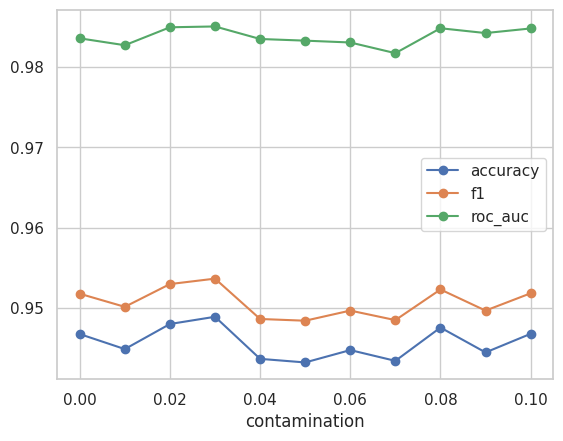

In [11]:
iso_results_df = pd.DataFrame(iso_results)
iso_results_df.plot(x='contamination', y=['accuracy', 'f1', 'roc_auc'], marker='o', grid=True)

In [12]:
iso_results_df

,contamination,accuracy,precision,recall,f1,roc_auc
0,0.00,0.946728,0.960463,0.943196,0.951751,0.983566
1,0.01,0.944854,0.959815,0.940614,0.950118,0.982707
2,0.02,0.947981,0.961284,0.944770,0.952956,0.984942
3,0.03,0.948882,0.962963,0.944480,0.953632,0.985046
4,0.04,0.943640,0.961564,0.935993,0.948606,0.983484
5,0.05,0.943192,0.955380,0.941503,0.948391,0.983277
6,0.06,0.944732,0.958503,0.940964,0.949653,0.983049
7,0.07,0.943389,0.957131,0.939954,0.948465,0.981718
8,0.08,0.947539,0.961272,0.943460,0.952283,0.984822
9,0.09,0.944440,0.956874,0.942535,0.949650,0.984222


Поведінка метрик немонотонна і нагадує статистичний шум, який може бути пов'язаний з тим, що відкидаючи різні частини датасету, ми формуємо різні навчальні та тестові датасети, невідтворюваний розподіл даних в яких незначним чином впливає на метрики моделі. Це схоже на коливання метрик моделі для навчального та тестового датасетів, які утворюються з базового датасету при різних значеннях random state у train_test_split. Проведемо відповідні обчислення та порівняємо результати.

In [13]:
rs_results = []
df = df1_mean.copy()

for rs in range (0, 11):

  acc, prec, rec, f1, roc = get_metrics(df=df, rs=rs)

  rs_results.append({
        "random state": rs,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    })

  print(f"Random state: {rs}")
  print(f"\n📊 Результати на відкладеному тесті:")
  print(f"Accuracy: {acc:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"Recall: {rec:.4f}")
  print(f"F1-score: {f1:.4f}")
  print(f"ROC-AUC: {roc:.4f}\n\n")

Random state: 0

📊 Результати на відкладеному тесті:
Accuracy: 0.9462
Precision: 0.9604
Recall: 0.9423
F1-score: 0.9513
ROC-AUC: 0.9839


Random state: 1

📊 Результати на відкладеному тесті:
Accuracy: 0.9446
Precision: 0.9560
Recall: 0.9441
F1-score: 0.9500
ROC-AUC: 0.9835


Random state: 2

📊 Результати на відкладеному тесті:
Accuracy: 0.9423
Precision: 0.9562
Recall: 0.9396
F1-score: 0.9478
ROC-AUC: 0.9830


Random state: 3

📊 Результати на відкладеному тесті:
Accuracy: 0.9465
Precision: 0.9596
Recall: 0.9437
F1-score: 0.9516
ROC-AUC: 0.9844


Random state: 4

📊 Результати на відкладеному тесті:
Accuracy: 0.9444
Precision: 0.9551
Recall: 0.9446
F1-score: 0.9498
ROC-AUC: 0.9829


Random state: 5

📊 Результати на відкладеному тесті:
Accuracy: 0.9450
Precision: 0.9581
Recall: 0.9424
F1-score: 0.9502
ROC-AUC: 0.9824


Random state: 6

📊 Результати на відкладеному тесті:
Accuracy: 0.9449
Precision: 0.9617
Recall: 0.9383
F1-score: 0.9499
ROC-AUC: 0.9817


Random state: 7

📊 Результати на в

<Axes: xlabel='random state'>

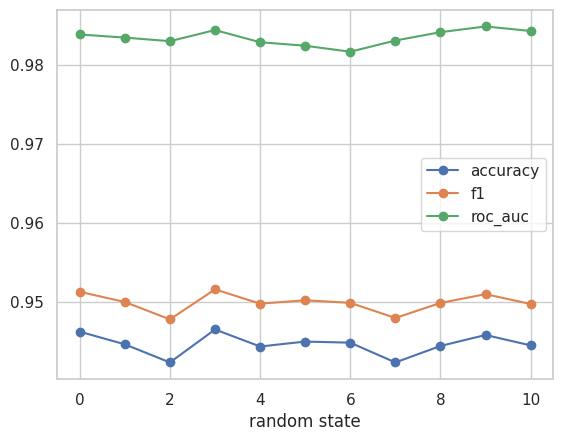

In [14]:
rs_results_df = pd.DataFrame(rs_results)
rs_results_df.plot(x='random state', y=['accuracy', 'f1', 'roc_auc'], marker='o', grid=True)

In [15]:
rs_results_df

,random state,accuracy,precision,recall,f1,roc_auc
0,0,0.946241,0.960428,0.942322,0.951289,0.983855
1,1,0.944641,0.956005,0.944070,0.950000,0.983463
2,2,0.942346,0.956168,0.939576,0.947799,0.983009
3,3,0.946519,0.959629,0.943695,0.951596,0.984416
4,4,0.944363,0.955062,0.944569,0.949787,0.982877
5,5,0.944989,0.958117,0.942447,0.950217,0.982432
6,6,0.944850,0.961740,0.938327,0.949889,0.981673
7,7,0.942346,0.953060,0.942946,0.947976,0.983095
8,8,0.944433,0.954608,0.945194,0.949878,0.984149
9,9,0.945824,0.958529,0.943571,0.950991,0.984874


При зміні random state в train_test_split, метрики мають дуже схожу немонотонну поведінку в практично тих самих діапазонах значень. Це свідчить про те, що виключення потенційних викидів з датасету не має впливу на метрики моделей, а ті коливання в значеннях метрик, що спостерігаються, обумовлені випадковими змінами в навчальному та тестовому датасетах.

Щоб пересвідчитися в цьому, розглянемо основні статистичні характеристики метрик в обох випадках та обчислимо різницю між ними.

In [16]:
iso_results_df.describe()

,contamination,accuracy,precision,recall,f1,roc_auc
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.050000,0.945649,0.959488,0.942007,0.950665,0.983784
std,0.033166,0.001999,0.002329,0.002607,0.001891,0.001077
min,0.000000,0.943192,0.955380,0.935993,0.948391,0.981718
25%,0.025000,0.944040,0.957817,0.940789,0.949128,0.983163
50%,0.050000,0.944854,0.959815,0.942535,0.950118,0.983566
75%,0.075000,0.947149,0.961278,0.943970,0.952045,0.984809
max,0.100000,0.948882,0.962963,0.944770,0.953632,0.985046


In [17]:
rs_results_df.describe()

,random state,accuracy,precision,recall,f1,roc_auc
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,5.000000,0.944641,0.957423,0.942549,0.949924,0.983467
std,3.316625,0.001354,0.002667,0.002101,0.001194,0.000958
min,0.000000,0.942346,0.953060,0.938327,0.947799,0.981673
25%,2.500000,0.944398,0.955533,0.941823,0.949764,0.982943
50%,5.000000,0.944641,0.958117,0.942946,0.949889,0.983463
75%,7.500000,0.945406,0.959079,0.943883,0.950604,0.984223
max,10.000000,0.946519,0.961740,0.945194,0.951596,0.984874


In [21]:
(iso_results_df.drop('contamination', axis=1).describe() - rs_results_df.drop('random state', axis=1).describe()).round(3)

,accuracy,precision,recall,f1,roc_auc
count,0.000,0.000,0.000,0.000,0.000
mean,0.001,0.002,-0.001,0.001,0.000
std,0.001,-0.000,0.001,0.001,0.000
min,0.001,0.002,-0.002,0.001,0.000
25%,-0.000,0.002,-0.001,-0.001,0.000
50%,0.000,0.002,-0.000,0.000,0.000
75%,0.002,0.002,0.000,0.001,0.001
max,0.002,0.001,-0.000,0.002,0.000


Різниця між основними статистичними характеристиками метрик моделей, обчислених у разі послідовного виключення різної кількості потенційних викидів з датасету (від 0% до 10% зразків в датасеті) та в разі формування різного розподілу на навчальну та тестову частину базового датасету за рахунок зміни random state в train_test_split, не перевищує 0,002.

Таким чином, отримані результати свідчать про відсутність суттєвих викидів у датасеті df1_mean, що підтверджує припущення про реальність спостережуваної неоднорідності даних.